In [1]:
import os
import torch.nn as nn
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader,random_split
import torch.nn as nn
from PIL import Image
from dataset import *
import matplotlib.pyplot as plt

test_dir = os.listdir("/workspace/breast_mri/3d_train/input")
test_path = ["/workspace/breast_mri/3d_train/input/"+f for f in test_dir]
test_path = sorted(test_path)

target_dir = os.listdir("/workspace/breast_mri/3d_train/breast")
target_path = ["/workspace/breast_mri/3d_train/breast/"+f for f in target_dir]
target_path = sorted(target_path)

len(test_path)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


106

torch.Size([1, 1, 16, 512, 512])


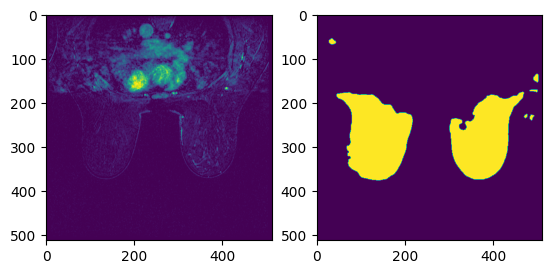

: 

In [7]:
import random
import nibabel as nib
from UNet_3d import UNet3D

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

set_seed(92653937)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = UNet3D(1,1)

model = nn.DataParallel(model,device_ids=[0,1,2,3])
model.load_state_dict(torch.load("/workspace/breast_mri/dir_checkpoint_3d_unet/best_model_3d_unet.pth"))
model.to(device)

image = nib.load(test_path[10])
img_np = image.get_fdata()

transforms = tio.Compose([
    tio.CropOrPad(target_shape=(16, 512, 512)),
    #tio.RandomAffine(degrees=(5)),
])

output = torch.tensor(np.expand_dims(img_np,axis=0)).to(device=device,dtype=torch.float32)
output = transforms(output)
output = output.unsqueeze(0)
print(output.shape)
output = model(output)
thresh = torch.zeros_like(output)
thresh[output>0.5]=1.0
thresh = thresh.detach().cpu().squeeze().squeeze()

plt.subplot(1,2,1)
plt.imshow(img_np[img_np.shape[0] // 2])
plt.subplot(1,2,2)
plt.imshow(np.array(thresh[thresh.shape[0]//2]))
